In [2]:
from network.examples import community, virus
from network.simulation import rv, test, run_simulations, create_runner
from network.randoms import fix_random
from network.graph import Graph

import random

import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
n_communities = 1000
community_size = 3
orphans = 1000
total_ppl = n_communities * community_size + orphans

# assume 3 strong connections per person
n_strong_conns = total_ppl * 3
# assume 6 weak connections per person
n_weak_conns = total_ppl * 6

core_kw = dict(strength=0.8)

def strong_kw_func(strength):
    def func():
        days_together = random.randint(1, 5)
        p_together = days_together / 7
        return dict(strength=p_together * strength)

    return func

strong_kw = strong_kw_func(strength=0.8)
weak_kw = dict(strength=0.1)

def generate_graph():
    graph, node_community_map = community.community_graph(
        n_communities, community_size, orphans,
        n_strong_conns, n_weak_conns,
        core_kw=core_kw, strong_kw=strong_kw, weak_kw=weak_kw
    )
    return graph

In [12]:
def reset_weak_edges(graph, strength):
    edges_to_remove = [edge for edge in graph.iter_edges() if edge.attr('kind') == 'weak']
    for prev_weak_edge in edges_to_remove:
        graph.remove_edge(prev_weak_edge.nodes)

    # generate edges will generate both outbound and inbound edges so we only need to /2
    n_new_weak_edges = int(len(edges_to_remove) / 2)
    for new_weak_edge in community.generate_edges(graph, n_new_weak_edges):
        graph.add_edge(new_weak_edge, kind='weak', strength=strength)
        
no_mitigation = create_runner(
    after=lambda transmission: reset_weak_edges(transmission.graph, weak_kw['strength'])
)

In [13]:
def enact_quarantine(transmission):
    graph = transmission.graph
    
    def should_remove_edge(edge):
        if edge.attr('kind') == 'strong':
            return True
        if edge.attr('kind') == 'weak' and test(0.75):
            return True
        return False
    
    if not transmission.props.get('in_quarantine', False):
        transmission.props['in_quarantine'] = True
        edges_to_remove = [e for e in graph.iter_edges() if should_remove_edge(e)]
        for edge in edges_to_remove:
            graph.remove_edge(edge.nodes)
        
def put_on_masks(transmission, mask_factor_core=0.9, mask_factor_strong=0.7, mask_factor_weak=0.2, perc_masks=1.0):
    graph = transmission.graph
    for edge in graph.iter_edges():
        if test(perc_masks):
            if edge.attr('kind') == 'core':
                graph.update_edge(edge.nodes, strength=mask_factor_core * edge.attr('strength'))  
            elif edge.attr('kind') == 'strong':
                graph.update_edge(edge.nodes, strength=mask_factor_strong * edge.attr('strength'))
            elif edge.attr('kind') == 'weak':
                graph.update_edge(edge.nodes, strength=mask_factor_weak * edge.attr('strength'))
                
def quarantine_and_mask(transmission):
    enact_quarantine(transmission)
    put_on_masks(transmission)
        
def runner_do_at(day, func):
    def after_func(transmission):
        reset_weak_edges(transmission.graph, weak_kw['strength'])
        if transmission.steps >= day:
            func(transmission)
    
    return create_runner(after=after_func)

In [14]:
def generate_sim(graph, runner):
    with fix_random():
        return virus.virus_simulation(
            graph=Graph.duplicate(graph),
            patient0=1,
            incubation_period=rv.randint(2, 14),
            contagious_for=rv.choice(0, 1, 7),
            runner=runner
        )

In [15]:
graph0 = generate_graph()

In [16]:
sim_control = generate_sim(graph0, runner=no_mitigation)
sim_quarantine = generate_sim(graph0, runner=runner_do_at(18, enact_quarantine))
sim_masks = generate_sim(graph0, runner=runner_do_at(18, put_on_masks))
sim_both = generate_sim(graph0, runner=runner_do_at(18, quarantine_and_mask))

In [17]:
results = run_simulations(
    sim_control,
    sim_quarantine,
    sim_masks,
    sim_both,
    to=80
)

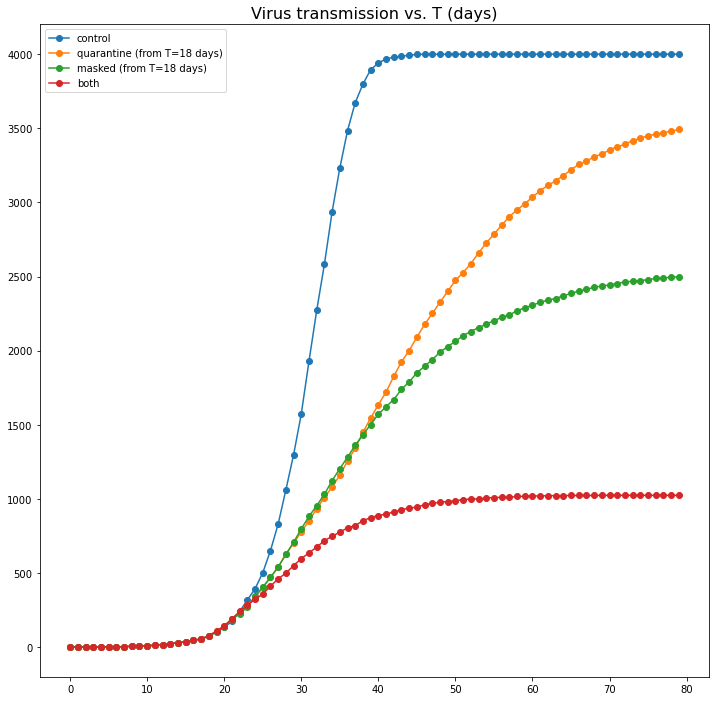

In [18]:
def sim_sequence(sim, n):
    for i in range(n):
        index = -1 if i >= len(sim.history) else i
        yield sim.history[index].broadcasts

fig = plt.figure(figsize=(12, 12))
plt.title('Virus transmission vs. T (days)', fontsize=16)
lines = []
for sim in results:
    line, = plt.plot(range(80), list(sim_sequence(sim, 80)), 'o-')
    lines.append(line)

plt.legend(
    lines, 
    ['control', 'quarantine (from T=18 days)', 'masked (from T=18 days)', 'both'], 
    loc='upper left'
)